<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/report_notebooks/autoenc%2Bclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries and packages

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorboard as tb
import visual_tools as vt
import utils
import matplotlib.pyplot as plt
import numpy as np
import time
import train

In [ ]:
# define image loader

def loaders():
    traintransform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize(128),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testtransform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize(128),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 32
    num_workers = 2

    trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return trainloader, testloader

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


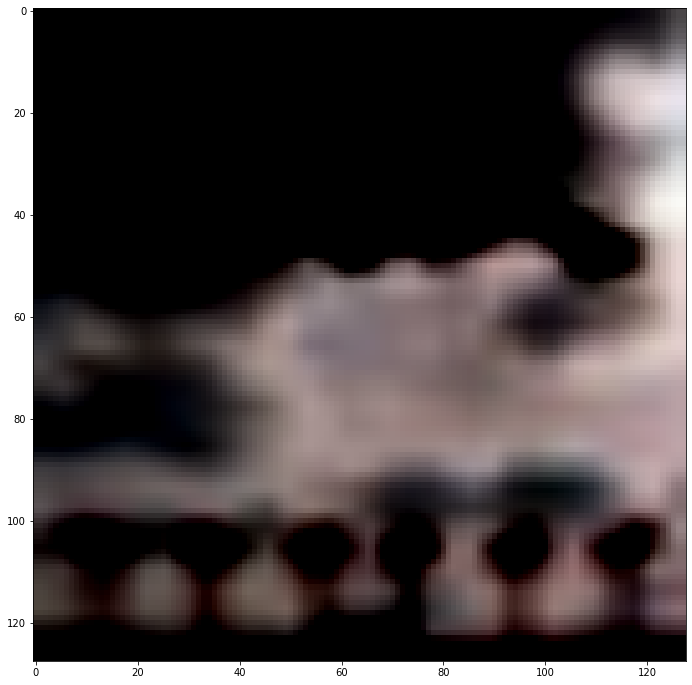

In [ ]:
# visualize data

trainloader, _ = loaders()
images, labels = next(iter(trainloader))
vt.show_image(images[0])

In [ ]:
# define classification training function

def train2(model, 
          loaders, 
          optimizer=None,
          criterion=nn.CrossEntropyLoss(), 
          epochs=5, 
          reload_=False):
        import time
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        if optimizer == None:
            optimizer = optim.Adam(params=model.parameters(), lr=0.001)
        trainloader, testloader = loaders()
    
        print("Training on: ", device)
        train_losses = []
        test_losses = []
        accuracies = []
        start_time = time.time()

        for epoch in range(epochs):
            
            print(f"New epoch: {epoch}")
            # training
            trainloss = []
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                out = model(images)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                trainloss.append(loss.item())
            trainloss = np.mean(trainloss)
            train_losses.append(trainloss)
            print(f"Training loss: {round(trainloss, 3)}")

            
            

            # validation
            testloss = []
            for images, labels in testloader:

                images, labels = images.to(device), labels.to(device)
                with torch.no_grad():
                    out = model(images)
                    loss = criterion(out, labels)
                    testloss.append(loss.item())
            testloss = np.mean(testloss)

            test_losses.append(testloss)
            print(f"Validation loss: {round(testloss, 3)}")
    
            # final accuracy
            
            accuracy = []
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                with torch.no_grad():
                    out = model(images)
                    topv, topi = torch.topk(out, 1, dim=1)
                    labels.resize_(*topi.shape)
                    eq = topi == labels
                    acc = torch.mean(eq.type(torch.FloatTensor))
                    accuracy.append(acc.item())
            accuracy = np.mean(accuracy)
            accuracies.append(accuracy)
            print(f"The accuracy is: {round(accuracy * 100, 1)}%")
            if reload_:
                trainloader, testloader = loaders()


            
    
            
    
        end_time = time.time()
        time = end_time - start_time
        print(time)
        return(time, train_losses, test_losses, accuracies)
  

In [ ]:
# make encoder part of autoencoder

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(4, 2)
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        return x
        
enc = Encoder()
enc(images).shape

torch.Size([32, 64, 15, 15])

In [ ]:
# create decoder part of autoencoder

 Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.Resize = transforms.Resize(128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.Resize(x)
        return x

decoder = Decoder()
decoder(enc(images)).shape

torch.Size([32, 3, 128, 128])

In [ ]:
# create autoencoder

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AutoEncoder()
model(images).shape
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (Resize): Resize(size=128, interpolation=PIL.Image.BILINEAR)
  )
)

In [ ]:
# create training

training2 = train.Training(autotrain=True)


In [ ]:
# train model

training2.train(model=model,
               loaders=loaders,
               optimizer=optim.Adam(params=model.parameters(), lr=0.001),
               criterion=nn.MSELoss(),
               epochs=10,
               reload_=False)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Validation loss: 0.246
Training loss: 0.014
New epoch: 1
Validation loss: 0.01
Training loss: 0.009
New epoch: 2
Validation loss: 0.008
Training loss: 0.008
New epoch: 3
Validation loss: 0.008
Training loss: 0.008
New epoch: 4
Validation loss: 0.008
Training loss: 0.007
New epoch: 5
Validation loss: 0.007
Training loss: 0.007
New epoch: 6
Validation loss: 0.007
Training loss: 0.007
New epoch: 7
Validation loss: 0.008
Training loss: 0.007
New epoch: 8
Validation loss: 0.007
Training loss: 0.007
New epoch: 9
Validation loss: 0.007
Training loss: 0.007


In [ ]:
# save model

torch.save(model.state_dict(), '10_2layered.model')

In [ ]:
# create classifier

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(14400, 10) 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

mod = Classifier()
mod(enc(images)).shape

torch.Size([32, 10])

In [ ]:
# create autoencoder with classifier

class AutoEncoder_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.classifier = Classifier()
    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.classifier(x)
        return x

model = AutoEncoder_classifier()
model(images).shape

torch.Size([32, 10])

In [ ]:
# load model

state_dict = torch.load("speckle_10_2layered.model")

In [ ]:
# load model wieghts for encoder part of autoencoder + classifier

from torch.nn.parameter import Parameter
def load_my_state_dict(self, state_dict):

    own_state = self.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
              continue
        if isinstance(param, Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)
load_my_state_dict(model, state_dict)
model

AutoEncoder_classifier(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=14400, out_features=10, bias=True)
  )
)

In [ ]:
# train model

time1, train_losses1, test_losses1, accuracies1 = train2(model=model,
               loaders=loaders,
               optimizer=optim.Adam(params=model.classifier.parameters(), lr=0.001),
               criterion=nn.CrossEntropyLoss(), reload_=True,
               epochs=20)

Files already downloaded and verified
Files already downloaded and verified
Training on:  cuda
New epoch: 0
Training loss: 1.594
Validation loss: 1.459
The accuracy is: 48.3%
Files already downloaded and verified
Files already downloaded and verified
New epoch: 1
Training loss: 1.391
Validation loss: 1.351
The accuracy is: 53.0%
Files already downloaded and verified
Files already downloaded and verified
New epoch: 2
Training loss: 1.314
Validation loss: 1.32
The accuracy is: 53.6%
Files already downloaded and verified
Files already downloaded and verified
New epoch: 3
Training loss: 1.264
Validation loss: 1.289
The accuracy is: 54.9%
Files already downloaded and verified
Files already downloaded and verified
New epoch: 4
Training loss: 1.227
Validation loss: 1.244
The accuracy is: 56.6%
Files already downloaded and verified
Files already downloaded and verified
New epoch: 5
Training loss: 1.195
Validation loss: 1.251
The accuracy is: 55.8%
Files already downloaded and verified
Files al